In [1]:
import os
import math
import pandas_datareader as web # stock values
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM1D, Conv2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
company = 'FB'

start = dt.datetime(2012,1,1)
end = dt.datetime(2021,1,1)
df = web.DataReader(company, 'yahoo', start, end)

df


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2020-12-24,270.399994,266.200012,268.880005,267.399994,6702000,267.399994
2020-12-28,277.299988,265.660004,268.739990,277.000000,23299700,277.000000
2020-12-29,280.510010,276.279999,276.950012,276.779999,16383000,276.779999


Text(0, 0.5, 'value')

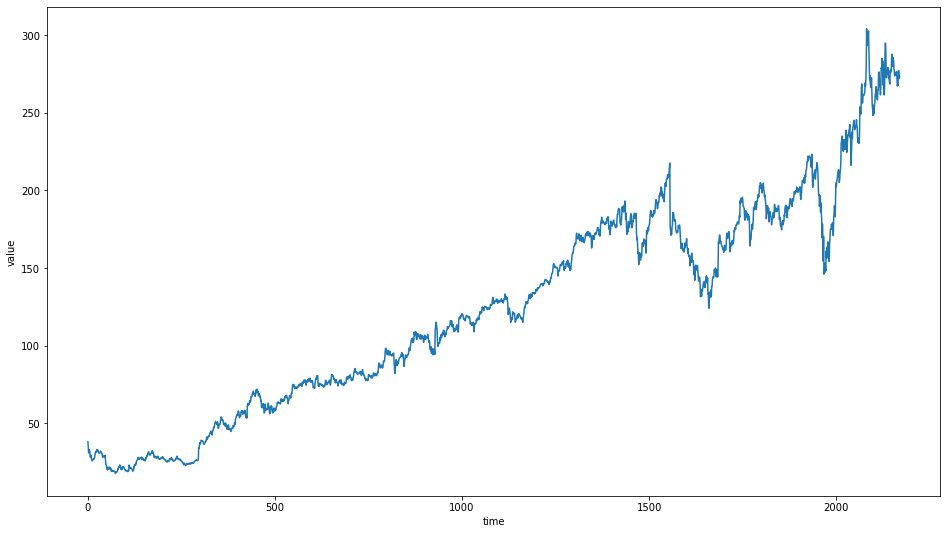

In [3]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=range(len(df)))
plt.xlabel('time')
plt.ylabel('value')

In [4]:
dataset = df[['High', 'Low', 'Open' ,'Close']].astype(float)
dataset.head()

,High,Low,Open,Close
Date,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999


In [5]:
# multi variables
cols = list(dataset)
cols

['High', 'Low', 'Open', 'Close']

In [6]:
# Preprocessing + reshape dataset  (time, var, values, channel=1)
scaler =  MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)


In [7]:
scaled_data = np.expand_dims(scaled_data, axis = 2)


In [12]:
scaled_data.shape

(2170, 4, 1)

In [13]:
# Split train/test data
train_dataset, test_dataset = np.vsplit(scaled_data, [int(len(dataset)*0.8)])


In [14]:
train_dataset.shape, test_dataset.shape

((1736, 4, 1), (434, 4, 1))

In [15]:
x_train = []
y_train = []

track = 7

for i in range(track, len(train_dataset)):
    x_train.append(train_dataset[i-track:i, 0:train_dataset.shape[1]])
    y_train.append(train_dataset[i:i+1, 0:train_dataset.shape[1]])

In [16]:
x_train, y_train = np.array(x_train), np.array(y_train)


In [17]:
x_train.shape, y_train.shape # n_samples, n_timesteps, n_features, channels

((1729, 7, 4, 1), (1729, 1, 4, 1))

In [18]:
model = Sequential()
model.add(ConvLSTM1D(filters=16, kernel_size=3, 
                     input_shape=(None, 4, 1),
                     padding="same", return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM1D(filters=16, kernel_size=3, 
                     padding="same", return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM1D(filters=16, kernel_size=3, 
                     padding="same", return_sequences=True))
model.add(BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m1d (ConvLSTM1D)    (None, None, 4, 16)       3328      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 4, 16)       64        
_________________________________________________________________
conv_lst_m1d_1 (ConvLSTM1D)  (None, None, 4, 16)       6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 4, 16)       64        
_________________________________________________________________
conv_lst_m1d_2 (ConvLSTM1D)  (None, None, 4, 16)       6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 4, 16)       64        
_________________________________________________________________
conv2d (Conv2D)              (None, None, 4, 1)        1

In [19]:
history = model.fit(x_train, y_train, epochs =50, batch_size=32,
                    validation_split=0.20, verbose=1)

Epoch 1/50
44/44 [==============================] - 12s 58ms/step - loss: 0.0203 - val_loss: 0.0102
Epoch 2/50
44/44 [==============================] - 2s 41ms/step - loss: 0.0023 - val_loss: 0.0108
Epoch 3/50
44/44 [==============================] - 2s 39ms/step - loss: 0.0023 - val_loss: 0.0106
Epoch 4/50
44/44 [==============================] - 2s 47ms/step - loss: 0.0015 - val_loss: 0.0107
Epoch 5/50
44/44 [==============================] - 2s 45ms/step - loss: 0.0015 - val_loss: 0.0101
Epoch 6/50
44/44 [==============================] - 2s 42ms/step - loss: 0.0016 - val_loss: 0.0103
Epoch 7/50
44/44 [==============================] - 2s 38ms/step - loss: 0.0016 - val_loss: 0.0120
Epoch 8/50
44/44 [==============================] - 2s 38ms/step - loss: 0.0010 - val_loss: 0.0120
Epoch 9/50
44/44 [==============================] - 2s 39ms/step - loss: 9.8337e-04 - val_loss: 0.0119
Epoch 10/50
44/44 [==============================] - 2s 38ms/step - loss: 0.0011 - val_loss: 0.0136
Epoc

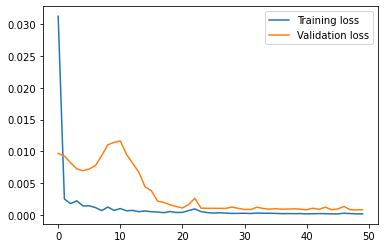

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [18]:
# forecast
x_test = []
y_test = []

for i in range(track, len(test_dataset)):
    x_test.append(test_dataset[i-track:i, 0:test_dataset.shape[1]])
    y_test.append(test_dataset[i:i+1, 0:test_dataset.shape[1]])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((427, 7, 4, 1), (427, 1, 4, 1))

In [19]:
forecast = model.predict(x_test)

In [20]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.00029002109658904374
Test Score:  0.008602876216173172


In [45]:
forecast_red[0,:,:]

array([[0.5551636 , 0.5715507 , 0.5720476 , 0.55209786],
       [0.57890767, 0.5838776 , 0.5822148 , 0.56536716],
       [0.5806093 , 0.59246236, 0.5874679 , 0.5648364 ],
       [0.57573867, 0.59357893, 0.5912197 , 0.56655025],
       [0.5702509 , 0.5935645 , 0.5881294 , 0.5708227 ],
       [0.5722227 , 0.59097534, 0.59090906, 0.58303624],
       [0.5638832 , 0.59110796, 0.58585924, 0.5633087 ]], dtype=float32)

In [26]:
# denormalize the predicted values
forecast_red = np.squeeze(forecast, axis=3)

y_pred=[]
for i in range(len(forecast_red)):
    y_pred.append(scaler.inverse_transform(forecast_red[i,:,:]))
    
y_pred = np.array(y_pred)

# reshape predictions
y_pred = np.reshape(y_pred, (-1, y_pred.shape[2]))

y_pred.shape

(2989, 4)

In [49]:
y_pred[:20]

array([[177.26886, 175.0122 , 179.44319, 175.72937],
       [184.06915, 178.40828, 182.31116, 179.52678],
       [184.5565 , 180.77338, 183.79295, 179.37488],
       [183.16156, 181.08098, 184.85127, 179.86536],
       [181.58986, 181.07701, 183.97955, 181.08804],
       [182.15459, 180.3637 , 184.76364, 184.58331],
       [179.76614, 180.40024, 183.33919, 178.9377 ],
       [177.47122, 175.56593, 179.36087, 175.61089],
       [184.15451, 178.52167, 182.13943, 179.03087],
       [184.65977, 181.17528, 183.98071, 179.18651],
       [183.46631, 181.28833, 185.6012 , 180.27892],
       [182.19667, 181.40295, 185.06361, 181.74548],
       [183.77525, 181.64534, 186.86217, 187.28062],
       [180.90784, 181.75954, 185.94385, 180.18161],
       [177.26843, 175.21234, 179.22258, 175.33084],
       [184.16324, 178.90979, 182.45082, 179.30888],
       [185.08817, 181.61899, 184.64954, 180.026  ],
       [184.31404, 181.96841, 186.39131, 181.30966],
       [184.12239, 183.6329 , 186.86658, 184.6

In [50]:
dataset[1729:1729+20]

,High,Low,Open,Close
Date,,,,
2019-04-04,178.000000,175.529999,176.020004,176.020004
2019-04-05,177.000000,175.100006,176.880005,175.720001
2019-04-08,175.500000,174.229996,175.210007,174.929993
2019-04-09,179.190002,175.550003,175.619995,177.580002
2019-04-10,178.789993,176.539993,178.179993,177.820007
2019-04-11,178.399994,177.000000,178.240005,177.509995
2019-04-12,179.630005,177.949997,178.000000,179.100006
2019-04-15,180.500000,176.869995,178.500000,179.649994
2019-04-16,180.169998,178.300003,179.000000,178.869995


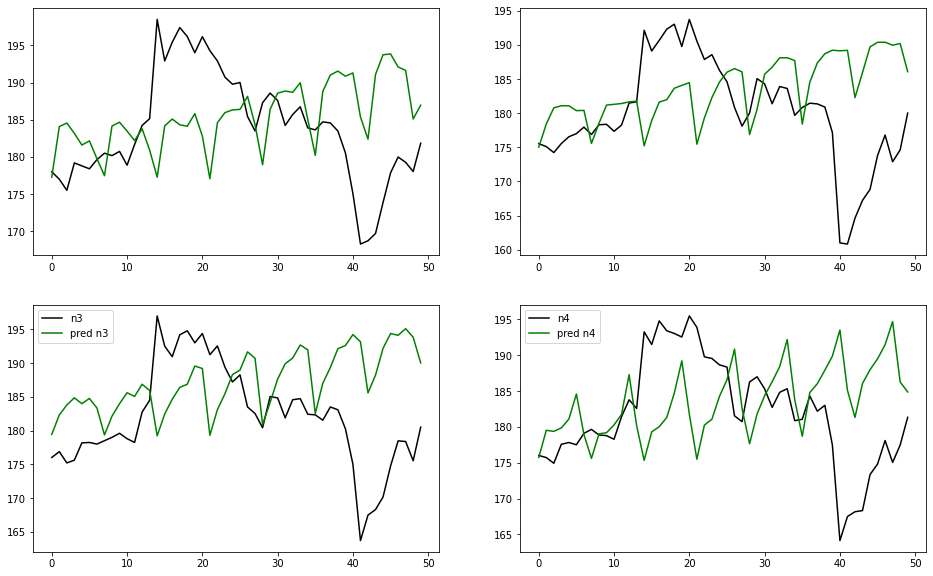

In [38]:
# Check Predictions
original = np.array(dataset[1729:1729+50])

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.plot(range(len(original)), original[:,0], color = 'black', label ='n1')
plt.plot(range(len(original)), y_pred[:len(original),0], color = 'green', label ='pred n1')


plt.subplot(2,2,2)
plt.plot(range(len(original)), original[:,1], color = 'black', label ='n2')
plt.plot(range(len(original)), y_pred[:len(original),1], color = 'green', label ='pred n2')


plt.subplot(2,2,3)
plt.plot(range(len(original)), original[:,2], color = 'black', label ='n3')
plt.plot(range(len(original)), y_pred[:len(original),2], color = 'green', label ='pred n3')
plt.legend()
plt.subplot(2,2,4)
plt.plot(range(len(original)), original[:,3], color = 'black', label ='n4')
plt.plot(range(len(original)), y_pred[:len(original),3], color = 'green', label ='pred n4')
plt.legend()

plt.show()

In [ ]:
# Check Predictions
dataset_exp = np.expand_dims(dataset, axis = 1)
original = dataset_exp[1729:]

In [ ]:

original.shape


In [ ]:
y_pred.shape

In [ ]:
dataset.shape

In [ ]:
dataset[1729:1729+10]

In [ ]:
y_pred[:1]

In [ ]:
# plotting

plt.plot()